No cosmic rays detected in Spectrum_1: 1024 points
Cosmic rays detected in Spectrum_1
No cosmic rays detected in Spectrum_2: 1024 points
Cosmic rays detected in Spectrum_2
No cosmic rays detected in Spectrum_3: 1024 points
Cosmic rays detected in Spectrum_3
No cosmic rays detected in Spectrum_4: 1024 points
Cosmic rays detected in Spectrum_4
No cosmic rays detected in Spectrum_5: 1024 points
Cosmic rays detected in Spectrum_5
  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum  -0.465744
1  Spectrum_1   -0.998045  Full_Spectrum  -0.405210
2  Spectrum_1   -0.996090  Full_Spectrum  -0.618884
3  Spectrum_1   -0.994135  Full_Spectrum  -0.586823
4  Spectrum_1   -0.992180  Full_Spectrum  -0.486247


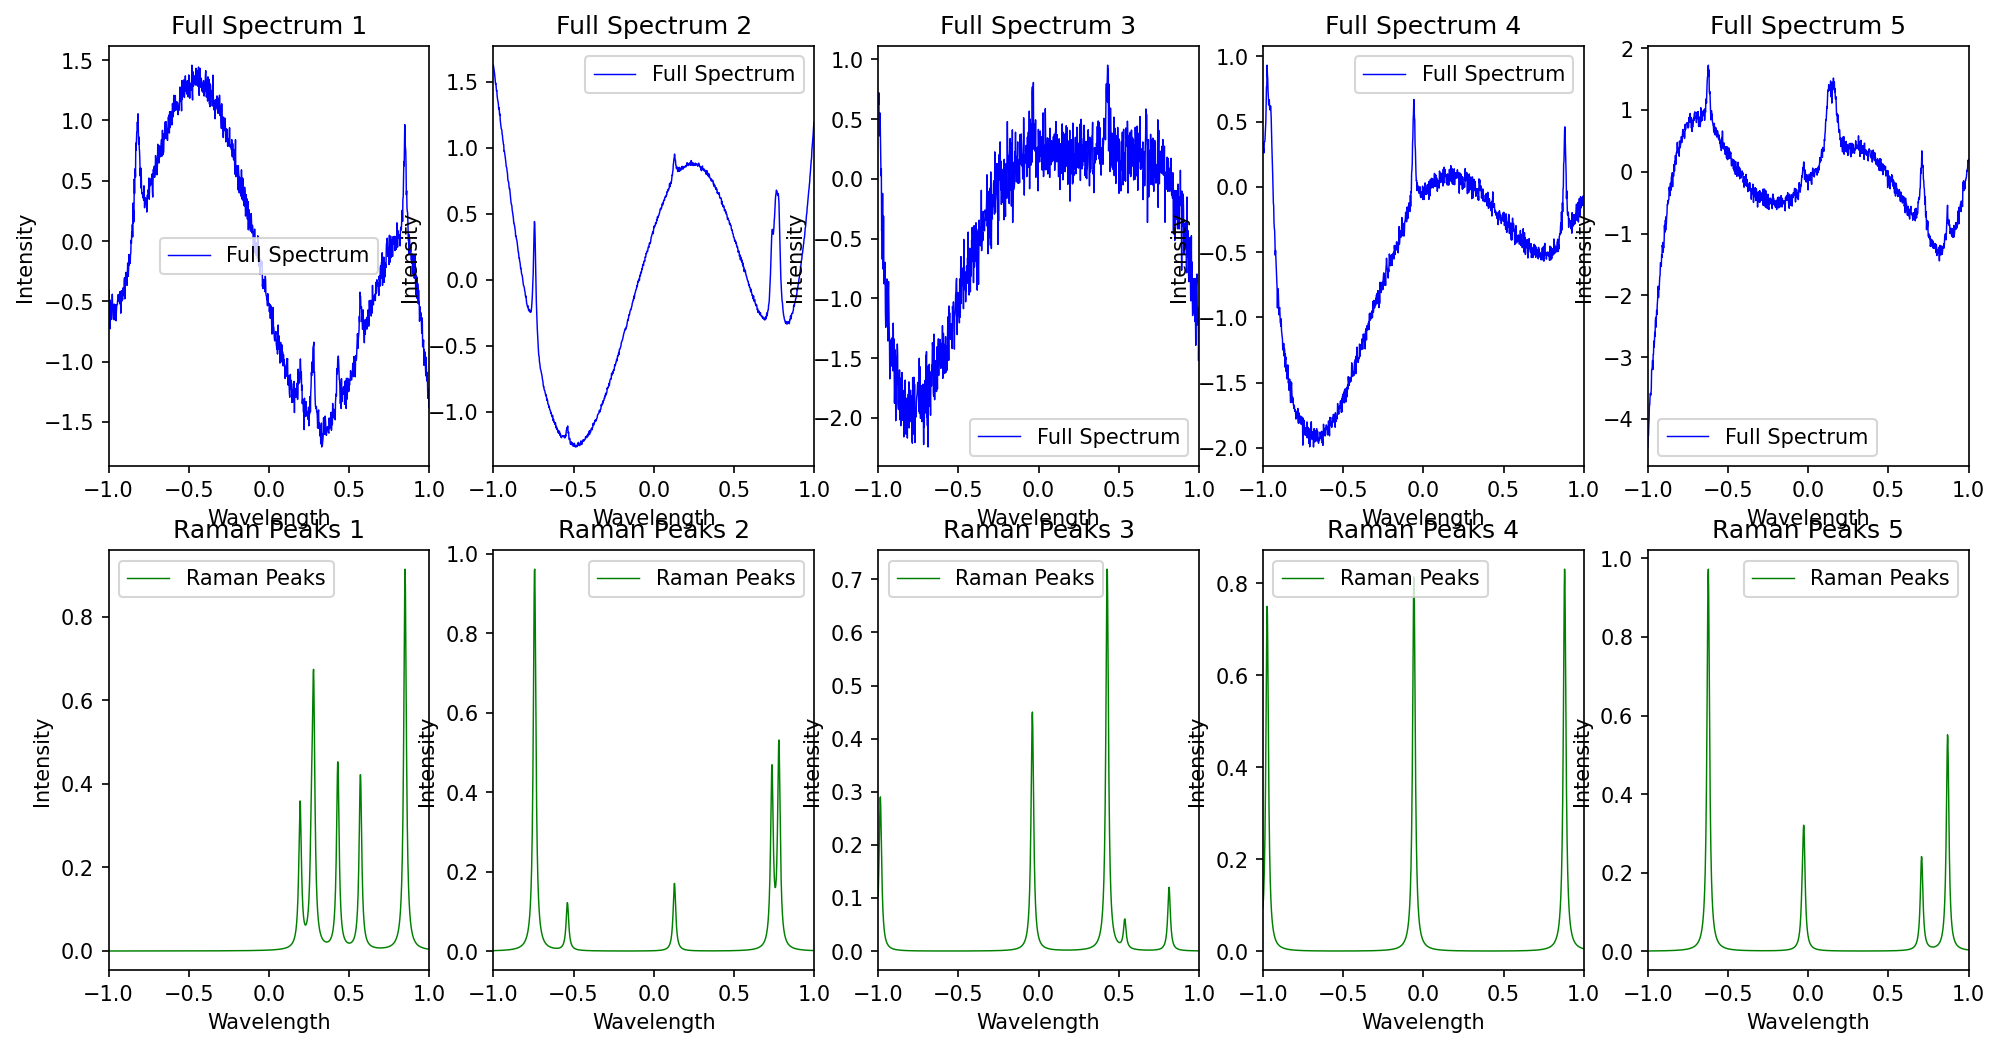

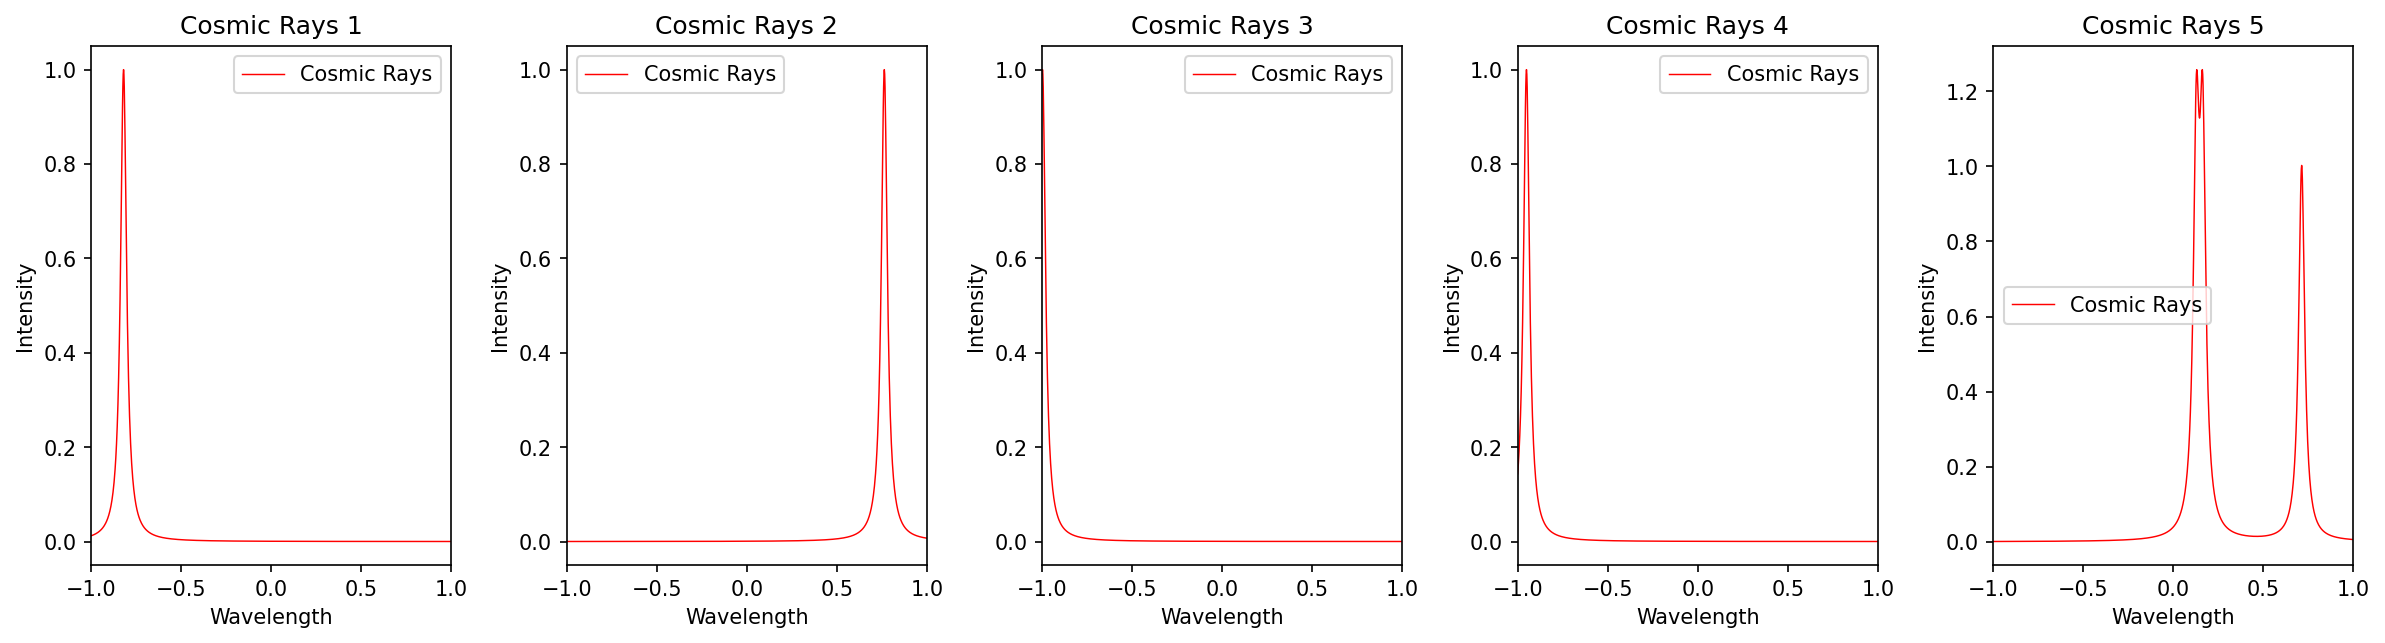

In [1]:
# SYNTHETIC SPECTRA 'ADDING CORRECTLY COSMIC RAYS'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []
        self.cosmic_rays_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Lorentzian peak with a width of 0, amplitudes: randomized between 0.8 & L2-norm of complete signal
    def add_cosmic_rays(self):
        cosmic_rays_spectrum = np.zeros_like(self.wavelengths)

        # Generate a random number of cosmic rays between 1 and 3
        num_cosmic_rays = np.random.randint(1, 4)

        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, np.linalg.norm(self.noisy_peaky_cheby))

            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))

            # Create cosmic ray using Lorentzian peak
            width_factor = 0.02
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2 + width_factor ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to separate array
            cosmic_rays_spectrum += cosmic_ray

        # Add rays to noise peaky cheby spectra
        self.noisy_peaky_cheby_rays = self.noisy_peaky_cheby + cosmic_rays_spectrum

        # Update Full Synthetic Spectrum
        full_spectrum = self.noisy_peaky_cheby_rays
        self.full_spectra_list.append(full_spectrum)

        # Update Raman Spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

        # Update Cosmic Rays
        self.cosmic_rays_list.append(cosmic_rays_spectrum)

        # Print information about detected cosmic rays
        cosmic_ray_indices = np.where(cosmic_rays_spectrum > 0)[0]
        spectrum_id = f'Spectrum_{len(self.full_spectra_list)}'

        # Check if cosmic_ray_indices is not empty and the indices are within a valid range
        if len(cosmic_ray_indices) > 0 and (min(cosmic_ray_indices) - 1 >= 0) and (max(cosmic_ray_indices) + 1 < len(full_spectrum)):
            print(f"Cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")
        else:
            print(f"No cosmic rays detected in {spectrum_id}: {len(cosmic_ray_indices)} points")
        
        # Check if cosmic rays are present in the spectrum
        if any(cosmic_rays_spectrum > 0):
            print(f"Cosmic rays detected in {spectrum_id}")
        else:
            print(f"No cosmic rays detected in {spectrum_id}")

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum, cosmic_rays) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list, self.cosmic_rays_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, cosmic_rays)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Cosmic_Rays',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)

        return df
    
# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    synthetic_data_generator.add_cosmic_rays()

# Save X & Y values
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display DataFrame
print(df.head())

# Plot high resolution (DPI)
plt.figure(figsize=(16, 8), dpi=150)

# Plot original spectra
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', linewidth=0.7, label='Full Spectrum')
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()
    
# Plot Raman peaks
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + num_spectra + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i], color='green', linewidth=0.7, label='Raman Peaks')
    plt.title(f'Raman Peaks {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()

# Plot cosmic rays only
plt.figure(figsize=(16, 8), dpi=150)
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.cosmic_rays_list[i], color='red', linewidth=0.7, label='Cosmic Rays')
    plt.title(f'Cosmic Rays {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())
    plt.legend()
     
# Show plots
plt.tight_layout()
plt.show()

  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum  -0.465744
1  Spectrum_1   -0.998045  Full_Spectrum  -0.405210
2  Spectrum_1   -0.996090  Full_Spectrum  -0.618884
3  Spectrum_1   -0.994135  Full_Spectrum  -0.586823
4  Spectrum_1   -0.992180  Full_Spectrum  -0.486247


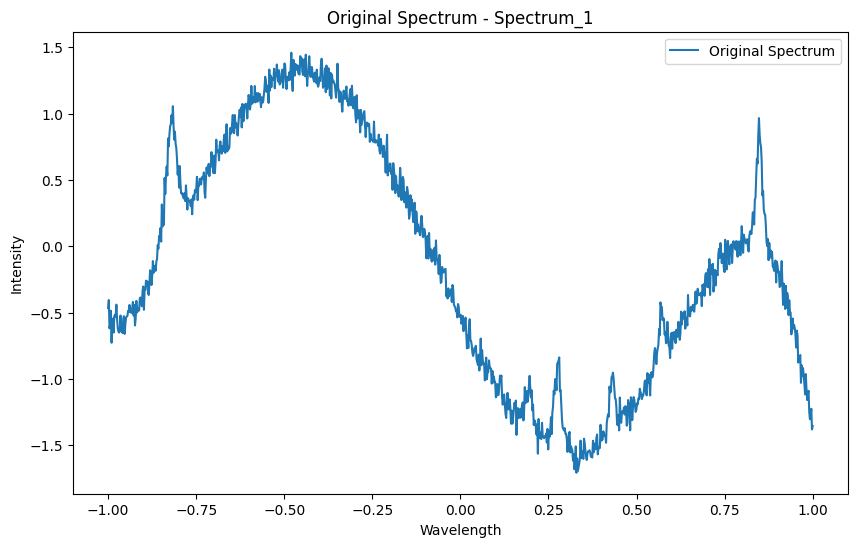

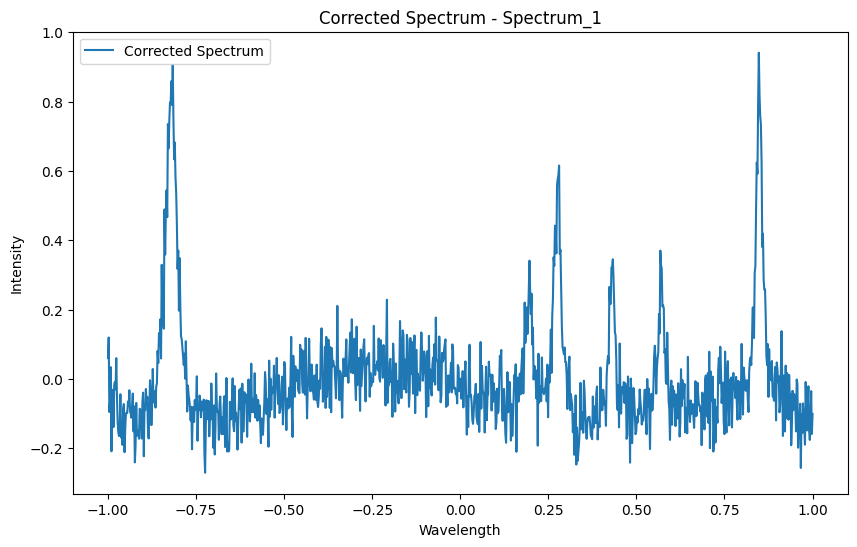

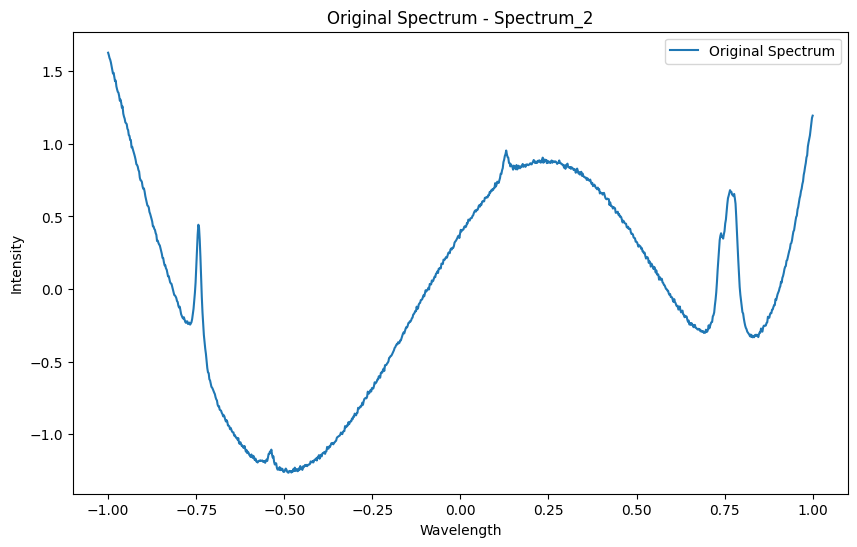

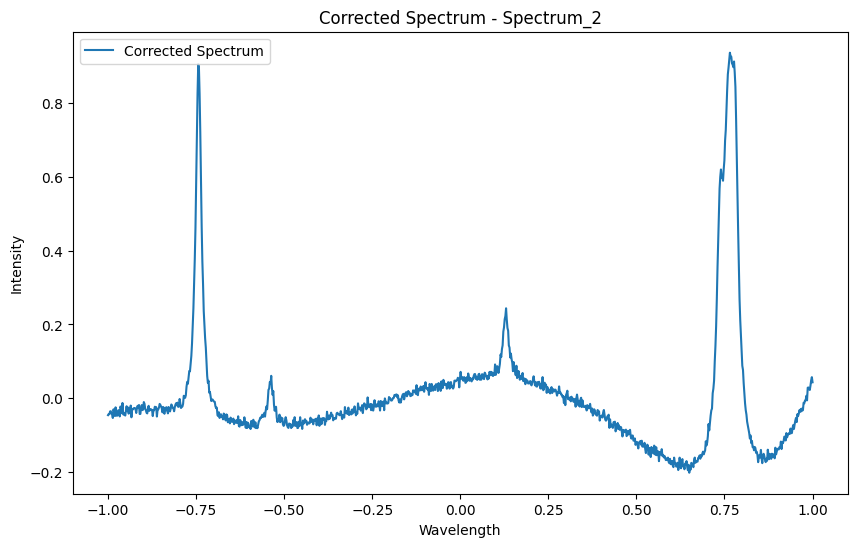

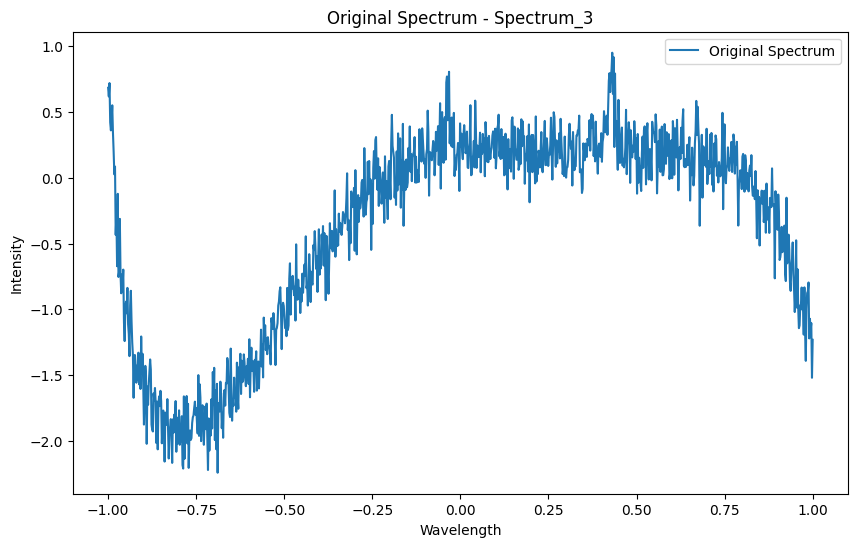

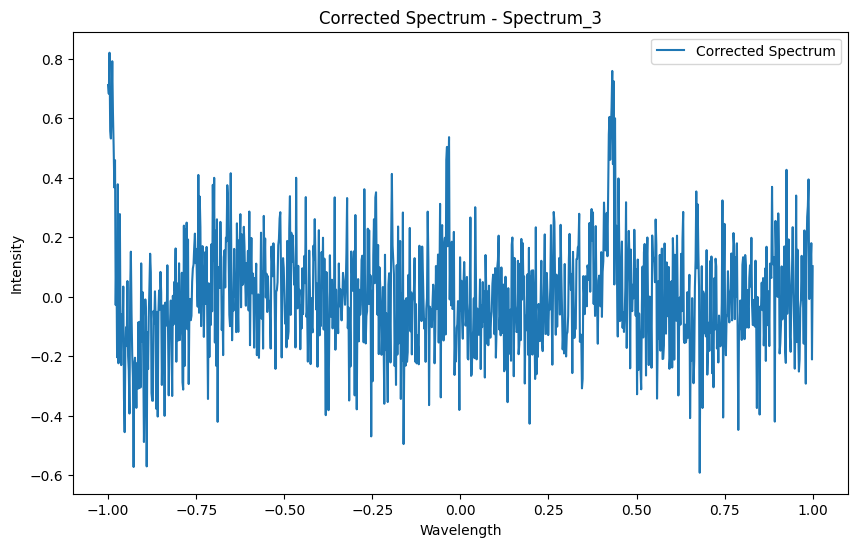

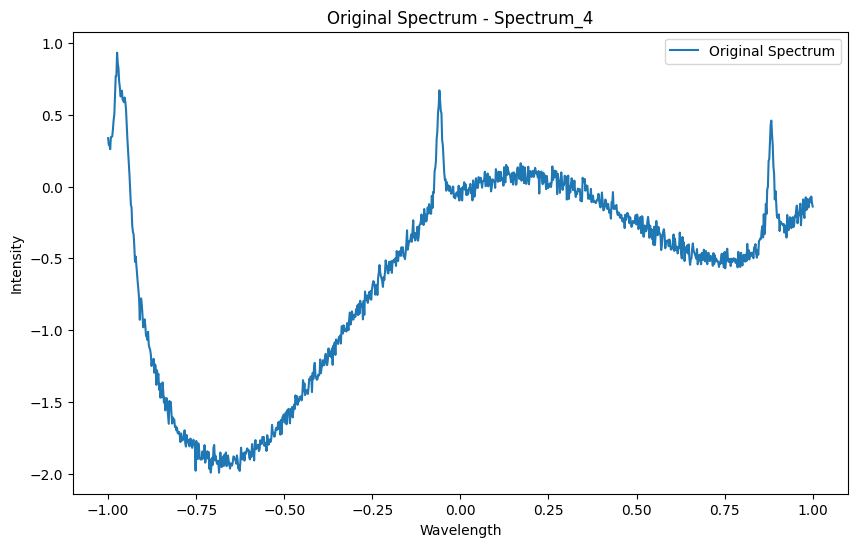

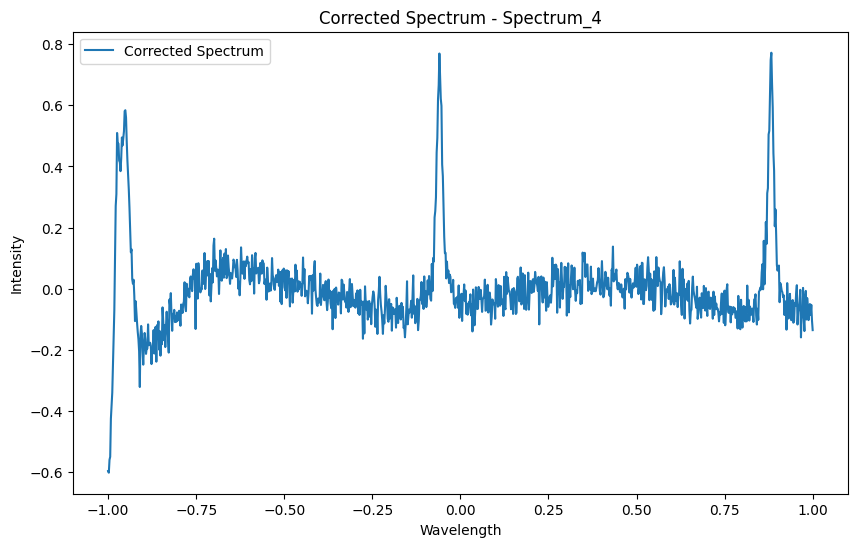

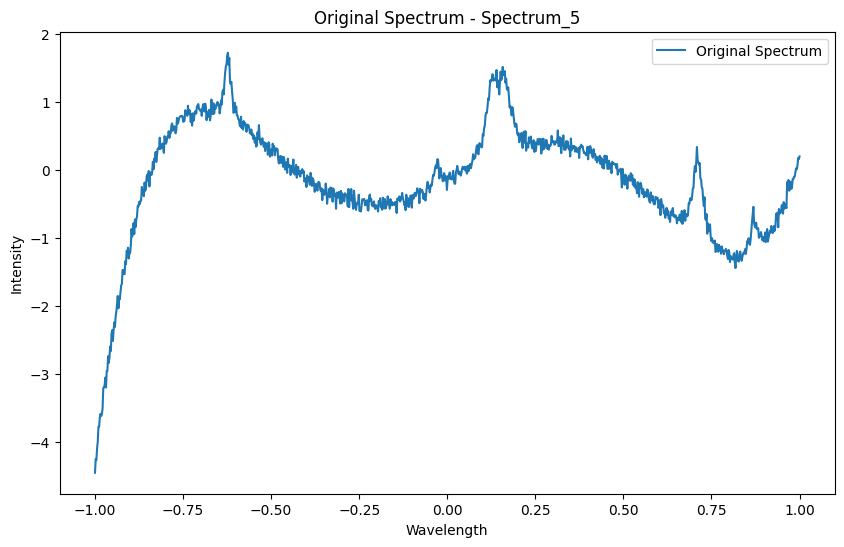

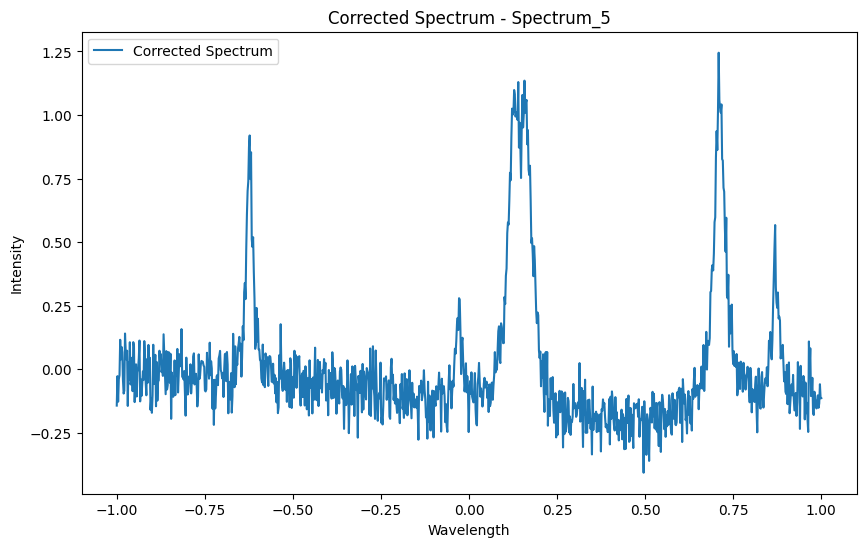

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

# Load data from the CSV file
df = pd.read_csv('synthetic_spectra.csv')

# Display the DataFrame to understand its structure
print(df.head())

def raman_baseline_correction(wavenumbers, spectrum, polynomial_order):
    def chebyshev_polynomial(x, *coefficients):
        return np.polynomial.chebyshev.chebval(x, coefficients)

    # Fit Chebyshev polynomial to the entire spectrum
    baseline_coefficients, _ = curve_fit(chebyshev_polynomial, wavenumbers, spectrum, p0=np.zeros(polynomial_order + 1))

    # Subtract the fitted polynomial from the original spectrum
    corrected_spectrum = spectrum - chebyshev_polynomial(wavenumbers, *baseline_coefficients)

    return baseline_coefficients, corrected_spectrum

# Plot the original, baseline, and corrected spectra separately for each spectrum
for i, spectrum_id in enumerate(df['Spectrum_ID'].unique()):
    # Extract relevant data for the current spectrum
    wavenumbers_spectrum = df[(df['Spectrum_ID'] == spectrum_id) & (df['Intensity_Type'] == 'Full_Spectrum')]['Wavelength'].values
    spectrum_spectrum = df[(df['Spectrum_ID'] == spectrum_id) & (df['Intensity_Type'] == 'Full_Spectrum')]['Intensity'].values

    # Check if the data is not empty
    if len(wavenumbers_spectrum) == 0 or len(spectrum_spectrum) == 0:
        continue

    # Perform baseline correction for the current spectrum
    polynomial_order_spectrum = 5  # Replace with your actual polynomial order
    baseline_coefficients_spectrum, corrected_spectrum_spectrum = raman_baseline_correction(wavenumbers_spectrum, spectrum_spectrum, polynomial_order_spectrum)

    # Plot the original spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(wavenumbers_spectrum, spectrum_spectrum, label='Original Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.title(f'Original Spectrum - {spectrum_id}')
    plt.legend()
    plt.show()

    # Plot the corrected spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(wavenumbers_spectrum, corrected_spectrum_spectrum, label='Corrected Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.title(f'Corrected Spectrum - {spectrum_id}')
    plt.legend()
    plt.show()